# Regression Using Multiple Inputs - Auto Price Prediction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing # Part of package scikit-learn
from sklearn.model_selection import train_test_split
import torch

# We are defaulting to CPU, but you may want to compare CPU vs GPU performance
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # Use cpu since this dataset is too small to take advantage of the GPU

In [2]:
# Get data
automobile_data = pd.read_parquet('../../inputs/autos.parquet', engine="pyarrow")
automobile_data.head() # Show results

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [3]:
# Clean data reducing to just the columns that impact price
# Here we can also change data types (ex: string to float), or do other cleanup.  Check datatype with .describe()
automobile_data = automobile_data.replace('?', np.nan) # replace with Not a Number NaN
automobile_data = automobile_data.dropna() # drop records with missing fields
# Determine what columns are important to determining price, and separate them into their own dataframe
col = ['make', 'fuel-type', 'body-style', 'horsepower']
automobile_features = automobile_data[col]
automobile_features.head() # Show results

,make,fuel-type,body-style,horsepower
3,audi,gas,sedan,102.0
4,audi,gas,sedan,115.0
6,audi,gas,sedan,110.0
8,audi,gas,sedan,140.0
10,bmw,gas,sedan,101.0


In [4]:
# Separate what we are trying to predict into its own dataframe
automobile_target = automobile_data[['price']]
automobile_target.head() # Show results

,price
3,13950.0
4,17450.0
6,17710.0
8,23875.0
10,16430.0


In [5]:
# Convert any column that is an enumeration into one boolean column per enumerated value (one hot encoding)
automobile_features = pd.get_dummies(automobile_features, columns=['make', 'fuel-type', 'body-style']) # Enums
automobile_features.columns # Show results

Index(['horsepower', 'make_audi', 'make_bmw', 'make_chevrolet', 'make_dodge',
       'make_honda', 'make_jaguar', 'make_mazda', 'make_mercedes-benz',
       'make_mitsubishi', 'make_nissan', 'make_peugot', 'make_plymouth',
       'make_porsche', 'make_saab', 'make_subaru', 'make_toyota',
       'make_volkswagen', 'make_volvo', 'fuel-type_diesel', 'fuel-type_gas',
       'body-style_convertible', 'body-style_hardtop', 'body-style_hatchback',
       'body-style_sedan', 'body-style_wagon'],
      dtype='object')

In [6]:
# Standardize numeric values to be centered around zero to reduce risk of vanishing or exploding gradients - subtract the mean then divide by the standard deviation
automobile_features[['horsepower']] = preprocessing.scale(automobile_features[['horsepower']])
automobile_features[['horsepower']].head() # Show results

,horsepower
3,0.201279
4,0.625812
6,0.462530
8,1.442223
10,0.168622


Epoch 1000 (10%), Loss: 67198083
Epoch 2000 (20%), Loss: 45334855
Epoch 3000 (30%), Loss: 34544821
Epoch 4000 (40%), Loss: 28241845
Epoch 5000 (50%), Loss: 24090537
Epoch 6000 (60%), Loss: 21137374
Epoch 7000 (70%), Loss: 18916107
Epoch 8000 (80%), Loss: 17176998
Epoch 9000 (90%), Loss: 15773529
Epoch 10000 (100%), Loss: 14611526


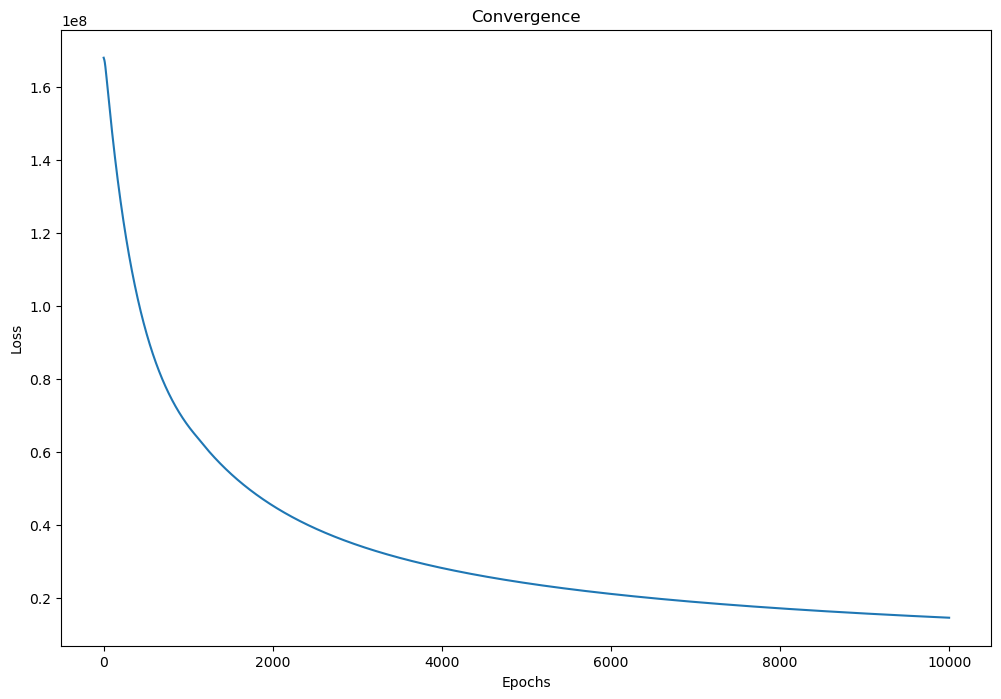

In [7]:
# Split dataset into 80% training data and 20% test data
x_train, x_test, y_train, y_test = train_test_split(automobile_features, automobile_target, test_size=0.2, random_state=0)
x_train_tensor = torch.from_numpy(x_train.values).float().to(device)
x_test_tensor = torch.from_numpy(x_test.values).float().to(device)
y_train_tensor = torch.from_numpy(y_train.values).float().to(device)
y_test_tensor = torch.from_numpy(y_test.values).float().to(device)
#Define model
input_size = 26 # Number of features/columns in our input dataset
hidden_size = 100
output_size = 1 # Number of predictions/columns in our output dataset (price)
model = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(), # sigmoid = # Activation 0 to 1
    torch.nn.Linear(hidden_size, output_size)
).to(device)
criterion = torch.nn.MSELoss() # Mean Squared Error loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001) # Stochastic Gradient Descent optimizer

# Train the model
def train(x_train_tensor, y_train_tensor, model, criterion, optimizer, num_epochs):
    total_loss = 0
    plot_losses = []
    model.train() # Put the model in "training mode", which turns on dropout and batch normalization
    for epoch in range(1, num_epochs+1):
        y_predicted = model(x_train_tensor)
        loss = criterion(y_predicted, y_train_tensor)
        optimizer.zero_grad()
        loss.backward() # Calculate gradients
        optimizer.step()
        total_loss += loss.item()
        if epoch % 1000 == 0:  # Show progress every 1000 passes
            percentComplete = epoch/num_epochs*100
            print(f'Epoch {epoch} ({percentComplete:.0f}%), Loss: {total_loss/epoch:.0f}')
        plot_losses.append(total_loss/epoch)
    return plot_losses

# Train the model
plot_losses = train(x_train_tensor, y_train_tensor, model, criterion, optimizer, num_epochs = 10000)
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(plot_losses)

In [8]:
# Test a single prediction
model.eval() # Put the model in "evaluation mode", this turns off dropout and batch normalization.
sample = x_test.iloc[23]
sample_tensor = torch.from_numpy(sample.values).float().to(device)
y_predicted = model(sample_tensor)
print("Predicted price of automobile is : ", int(y_predicted.item()))
print("Actual price of automobile is : ", int(y_test.iloc[23]))

Predicted price of automobile is :  8061
Actual price of automobile is :  8495


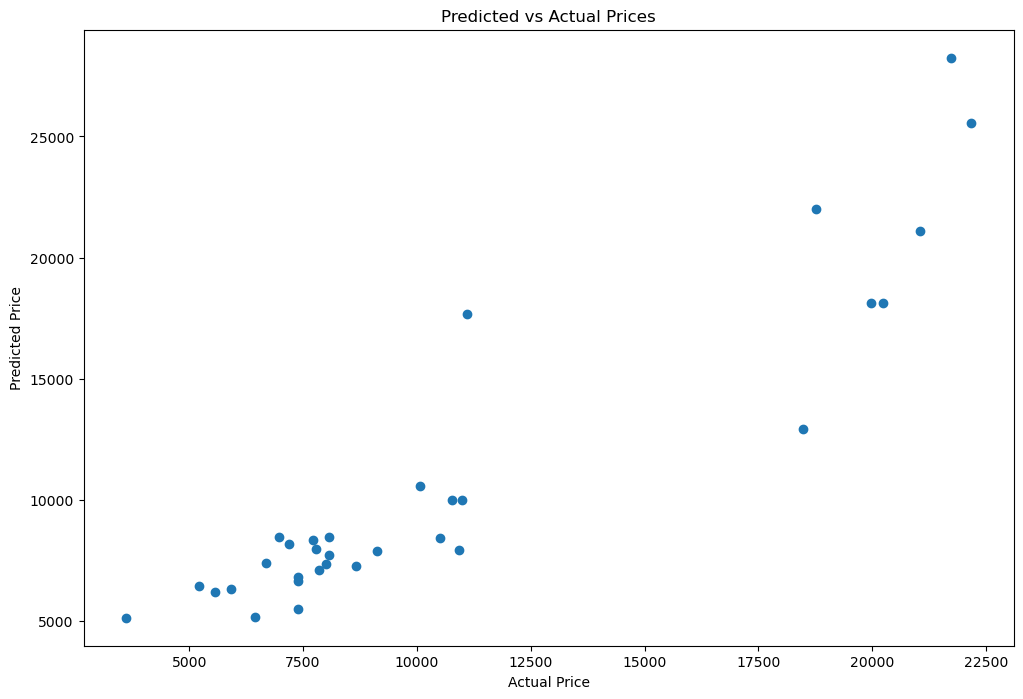

In [9]:
# Test all predictions and plot results
y_prediction_tensor = model(x_test_tensor)
y_predicted = y_prediction_tensor.detach().cpu().numpy()
plt.figure(figsize=(12,8))
plt.scatter(y_predicted, y_test.values)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.show()

In [10]:
# Save model to file
path = '../../outputs/autos_model.pth'
torch.save(model, path)

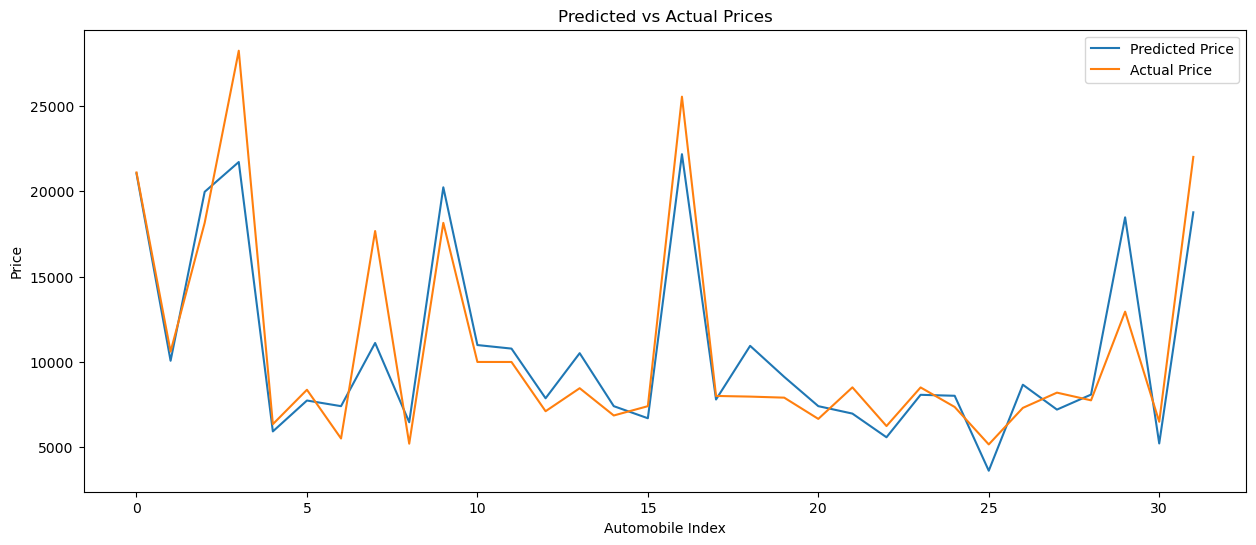

In [11]:
# Use existing model and plot on line chart
saved_model = torch.load(path)
saved_model.eval() # Put the model in "evaluation mode", this turns off dropout and batch normalization.
y_prediction_tensor = saved_model(x_test_tensor).to(device)
y_predicted = y_prediction_tensor.detach().cpu().numpy()
plt.figure(figsize=(15,6))
plt.plot(y_predicted, label='Predicted Price')
plt.plot(y_test.values, label='Actual Price')
plt.title("Predicted vs Actual Prices")
plt.xlabel("Automobile Index")
plt.ylabel("Price")
plt.legend()
plt.show()